In [93]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from random import randrange, seed
from matplotlib.image import imread
from keras.models import Model
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dropout, Dense
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
link_test = 'https://drive.google.com/file/d/10kc9oBGbmtSZS8oQ6zilF_yzhOPzgtKz/view?usp=sharing'
link_train = 'https://drive.google.com/file/d/1wrPV8lm4FujT097ygNT4rARwYAsD7prm/view?usp=sharing'

# to get the id part of the file
id_test = link_test.split("/")[-2]
id_train = link_train.split("/")[-2]

downloaded = drive.CreateFile({'id':id_test})
downloaded.GetContentFile('test.zip')

downloaded = drive.CreateFile({'id':id_train})
downloaded.GetContentFile('train.zip')

In [ ]:
%%time

!unzip test.zip -d test/
!unzip train.zip -d train/

## Loading data

In [15]:
image_dir = "train/train"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.6534.jpg,cat
1,cat.1431.jpg,cat
2,cat.2233.jpg,cat
3,dog.5920.jpg,dog
4,dog.6674.jpg,dog


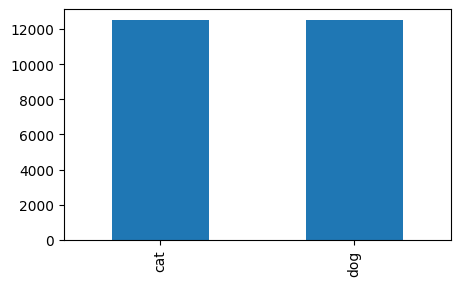

In [21]:
plt.figure(figsize=(5, 3))
data['label'].value_counts().plot.bar()
plt.show()

## EDA

In [26]:
seed(13)

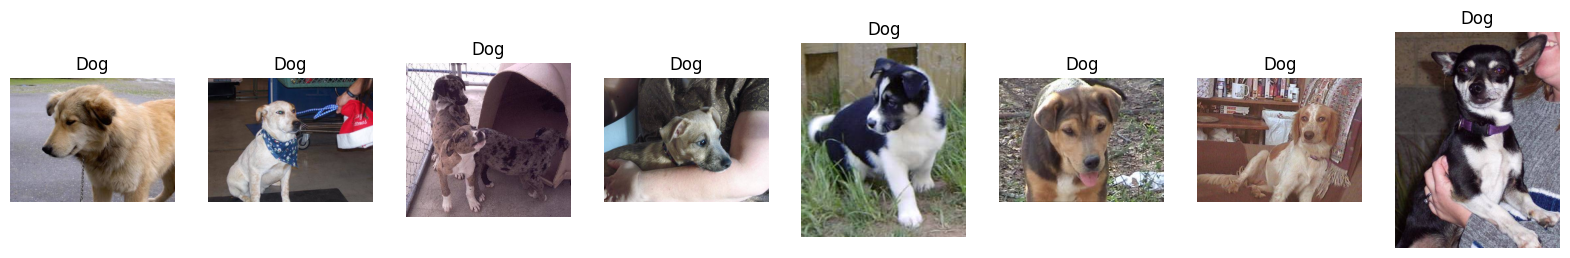

In [27]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

for i in range(8):
    plt.subplot(1, 8, i+1)
    filename = 'train/train/' + 'dog.' + str(randrange(1, 2500)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog', fontsize=12)
    plt.axis('off')

plt.show()

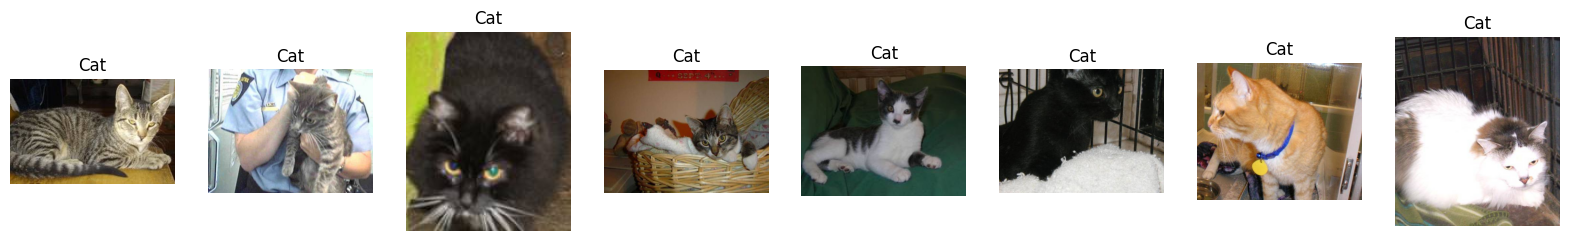

In [30]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)
lenght = len(data)

for i in range(8):

    plt.subplot(1, 8, i+1)
    filename = 'train/train/' + 'cat.' + str(randrange(1, 2500)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat', fontsize=12)
    plt.axis('off')

plt.show()

**Find median size of image for model building**

In [29]:
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

image_width = []
image_height = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)

median_width = np.median(image_width)
median_height = np.median(image_height)

print('median_size:', median_width,  'X', median_height)

median_size: 447.0 X 374.0


The median size 447*374. Therefor we will be use size = (370, 370)

In [34]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state=13)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state=13)

print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)
print('The shape of validation data', X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


**Create image data generator**

In [91]:
batch_size = 64
size = (370, 370)
idg = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator()

In [41]:
train_idg = idg.flow_from_dataframe(X_train,
                                    "train/train/",
                                    x_col="filename",
                                    y_col="label",
                                    batch_size=batch_size,
                                    target_size=size)

Found 20000 validated image filenames belonging to 2 classes.


In [43]:
val_idg = idg.flow_from_dataframe(X_val,
                                  "train/train/",
                                  x_col="filename",
                                  y_col="label",
                                  batch_size=batch_size,
                                  target_size=size,
                                  shuffle=False)

Found 2500 validated image filenames belonging to 2 classes.


In [46]:
test_idg = idg.flow_from_dataframe(X_test,
                                   "train/train/",
                                   x_col="filename",
                                   y_col="label",
                                   batch_size=batch_size,
                                   target_size=size,
                                   shuffle=False)

Found 2500 validated image filenames belonging to 2 classes.


## Modeling

In [49]:
# Download vgg16 model and freeze the weights
vgg16_model = VGG16(include_top=False, input_shape=(370, 370, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [50]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

In [51]:
# We need freezing the weights of all the layers in the VGG16 model by setting
# layer.trainable = False
# The vgg16 derived weights will not be trained during the training of final model

for layer in vgg16_model.layers:
    layer.trainable = False

In [54]:
# Define our model

flat = Flatten()(vgg16_model.output)
dropout1 = Dropout(0.2, name="Dropout1")(flat)
dense1 = Dense(128, activation="relu")(dropout1)
dropout2 = Dropout(0.2, name="Dropout2")(dense1)
output = Dense(2, activation="softmax")(dropout2)

final_model = Model(inputs=[vgg16_model.input], outputs=[output])

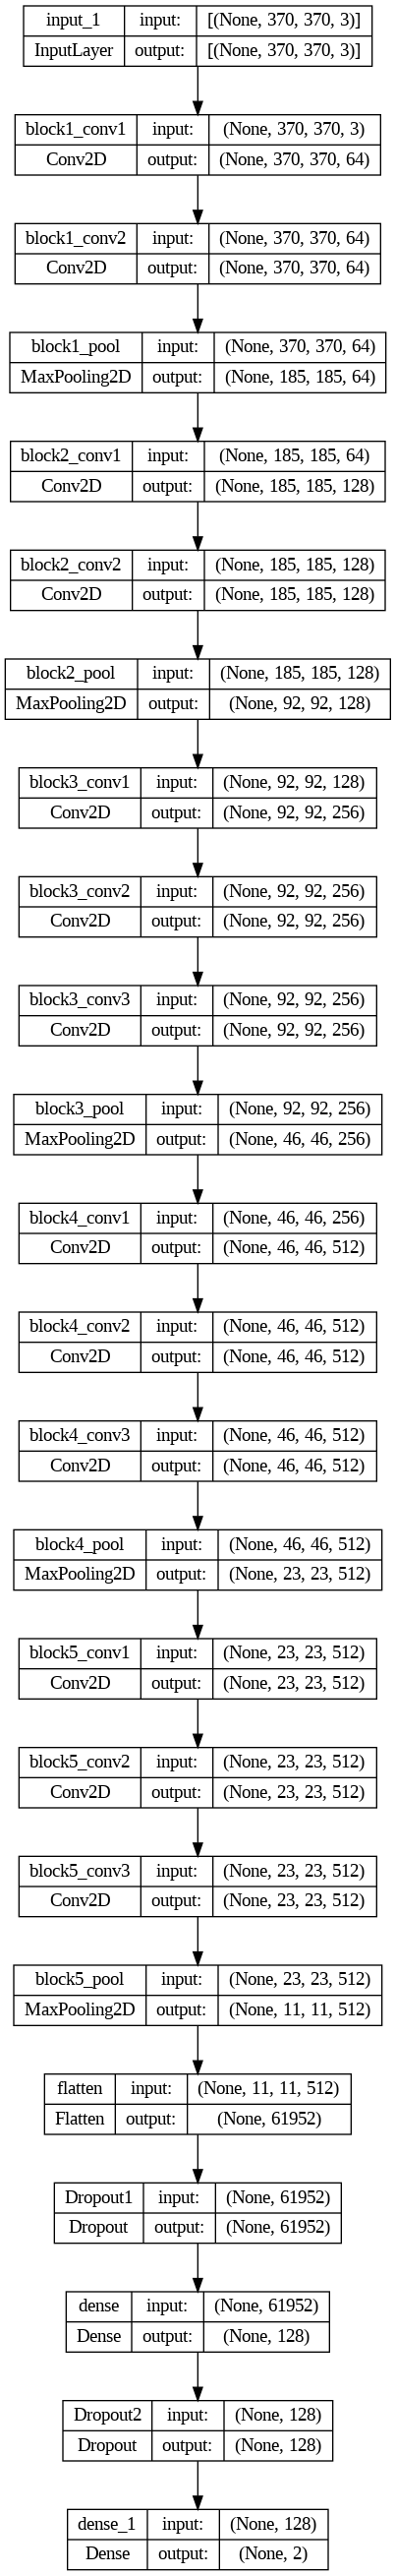

In [56]:
plot_model(final_model, show_shapes=True, show_layer_names=True)

In [59]:
final_model.compile(optimizer='adam',
                    loss=categorical_crossentropy,
                    metrics=["accuracy"])

In [63]:
# The ModelCheckpoint callback will save the best model during training based
# on the validation loss
model_ckpt = ModelCheckpoint("Dog_Cat",
                             monitor="val_loss",
                             save_best_only=True)

In [66]:
# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
# EarlyStopping: Stop training when a monitored metric has stopped improving

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

early_stoping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              restore_best_weights=True,
                              verbose=1)

In [65]:
%%time
# The first attempt to improve accuracy
history = final_model.fit(train_idg,
                          batch_size=batch_size,
                          validation_data=val_idg,
                          epochs=10,
                          callbacks=[model_ckpt])

Epoch 1/10
313/313 [==============================] - 326s 949ms/step - loss: 1.4324 - accuracy: 0.9456 - val_loss: 0.0598 - val_accuracy: 0.9668
Epoch 2/10
313/313 [==============================] - 285s 910ms/step - loss: 0.0579 - accuracy: 0.9768 - val_loss: 0.0466 - val_accuracy: 0.9824
Epoch 3/10
313/313 [==============================] - 283s 904ms/step - loss: 0.0440 - accuracy: 0.9832 - val_loss: 0.0479 - val_accuracy: 0.9824
Epoch 4/10
313/313 [==============================] - 286s 913ms/step - loss: 0.0361 - accuracy: 0.9834 - val_loss: 0.0434 - val_accuracy: 0.9832
Epoch 5/10
313/313 [==============================] - 281s 899ms/step - loss: 0.0277 - accuracy: 0.9864 - val_loss: 0.0652 - val_accuracy: 0.9824
Epoch 6/10
313/313 [==============================] - 280s 895ms/step - loss: 0.0267 - accuracy: 0.9858 - val_loss: 0.0517 - val_accuracy: 0.9864
Epoch 7/10
313/313 [==============================] - 290s 927ms/step - loss: 0.0289 - accuracy: 0.9879 - val_loss: 0.0604 -

In [68]:
%%time
# The second attempt to improve accuracy
cat_dog2 = final_model.fit(train_idg,
                           batch_size=batch_size,
                           validation_data=val_idg,
                           epochs=10,
                           callbacks=[early_stoping, learning_rate_reduction, model_ckpt])

Epoch 1/10
313/313 [==============================] - 291s 927ms/step - loss: 0.0202 - accuracy: 0.9921 - val_loss: 0.0752 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 280s 895ms/step - loss: 0.0164 - accuracy: 0.9930 - val_loss: 0.0751 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 281s 896ms/step - loss: 0.0205 - accuracy: 0.9912 - val_loss: 0.0855 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9893
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 [==============================] - 281s 896ms/step - loss: 0.0234 - accuracy: 0.9893 - val_loss: 0.0775 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 290s 926ms/step - loss: 0.0186 - accuracy: 0.9917 - val_loss: 0.0601 - val_accuracy: 0.9864 - lr: 5.0000e-04
Epoch 6/10
313/313 [====================

## Plot the results

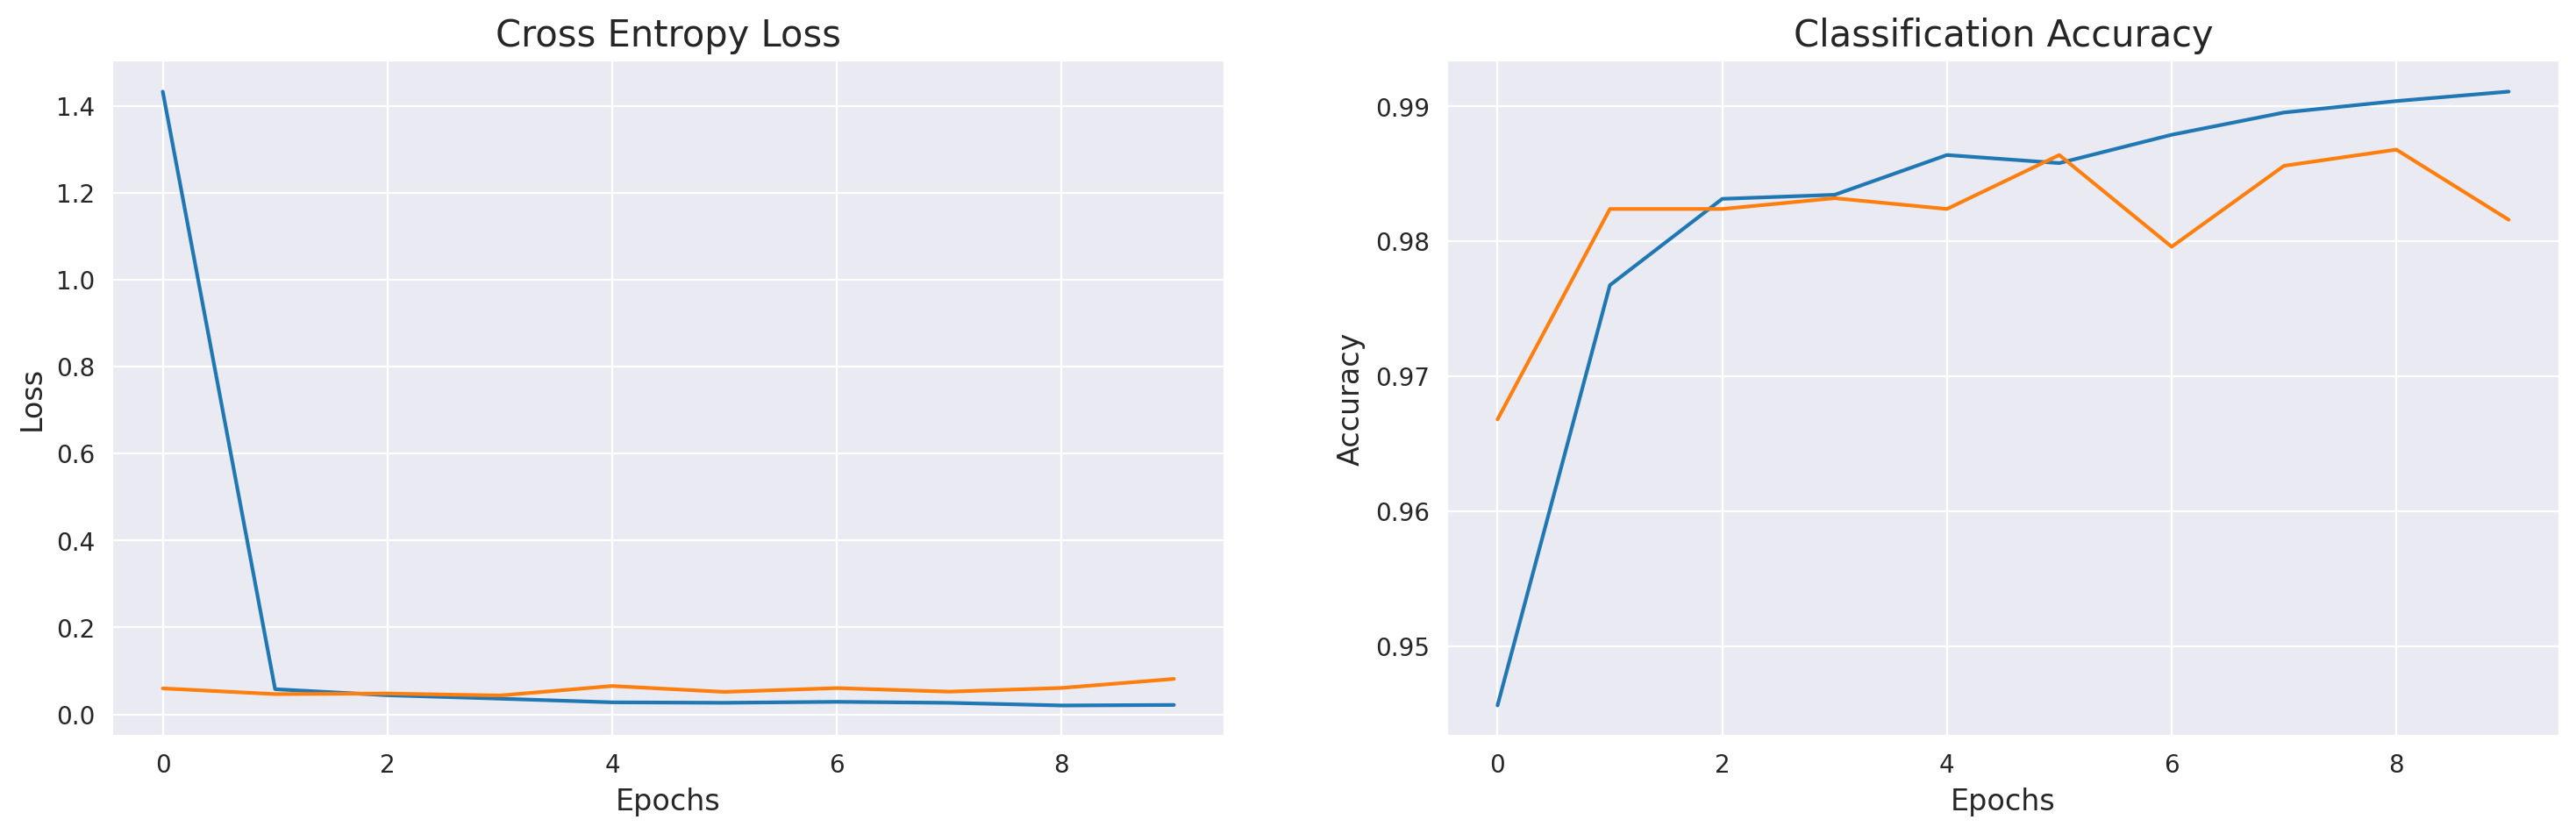

In [69]:
error = pd.DataFrame(history.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

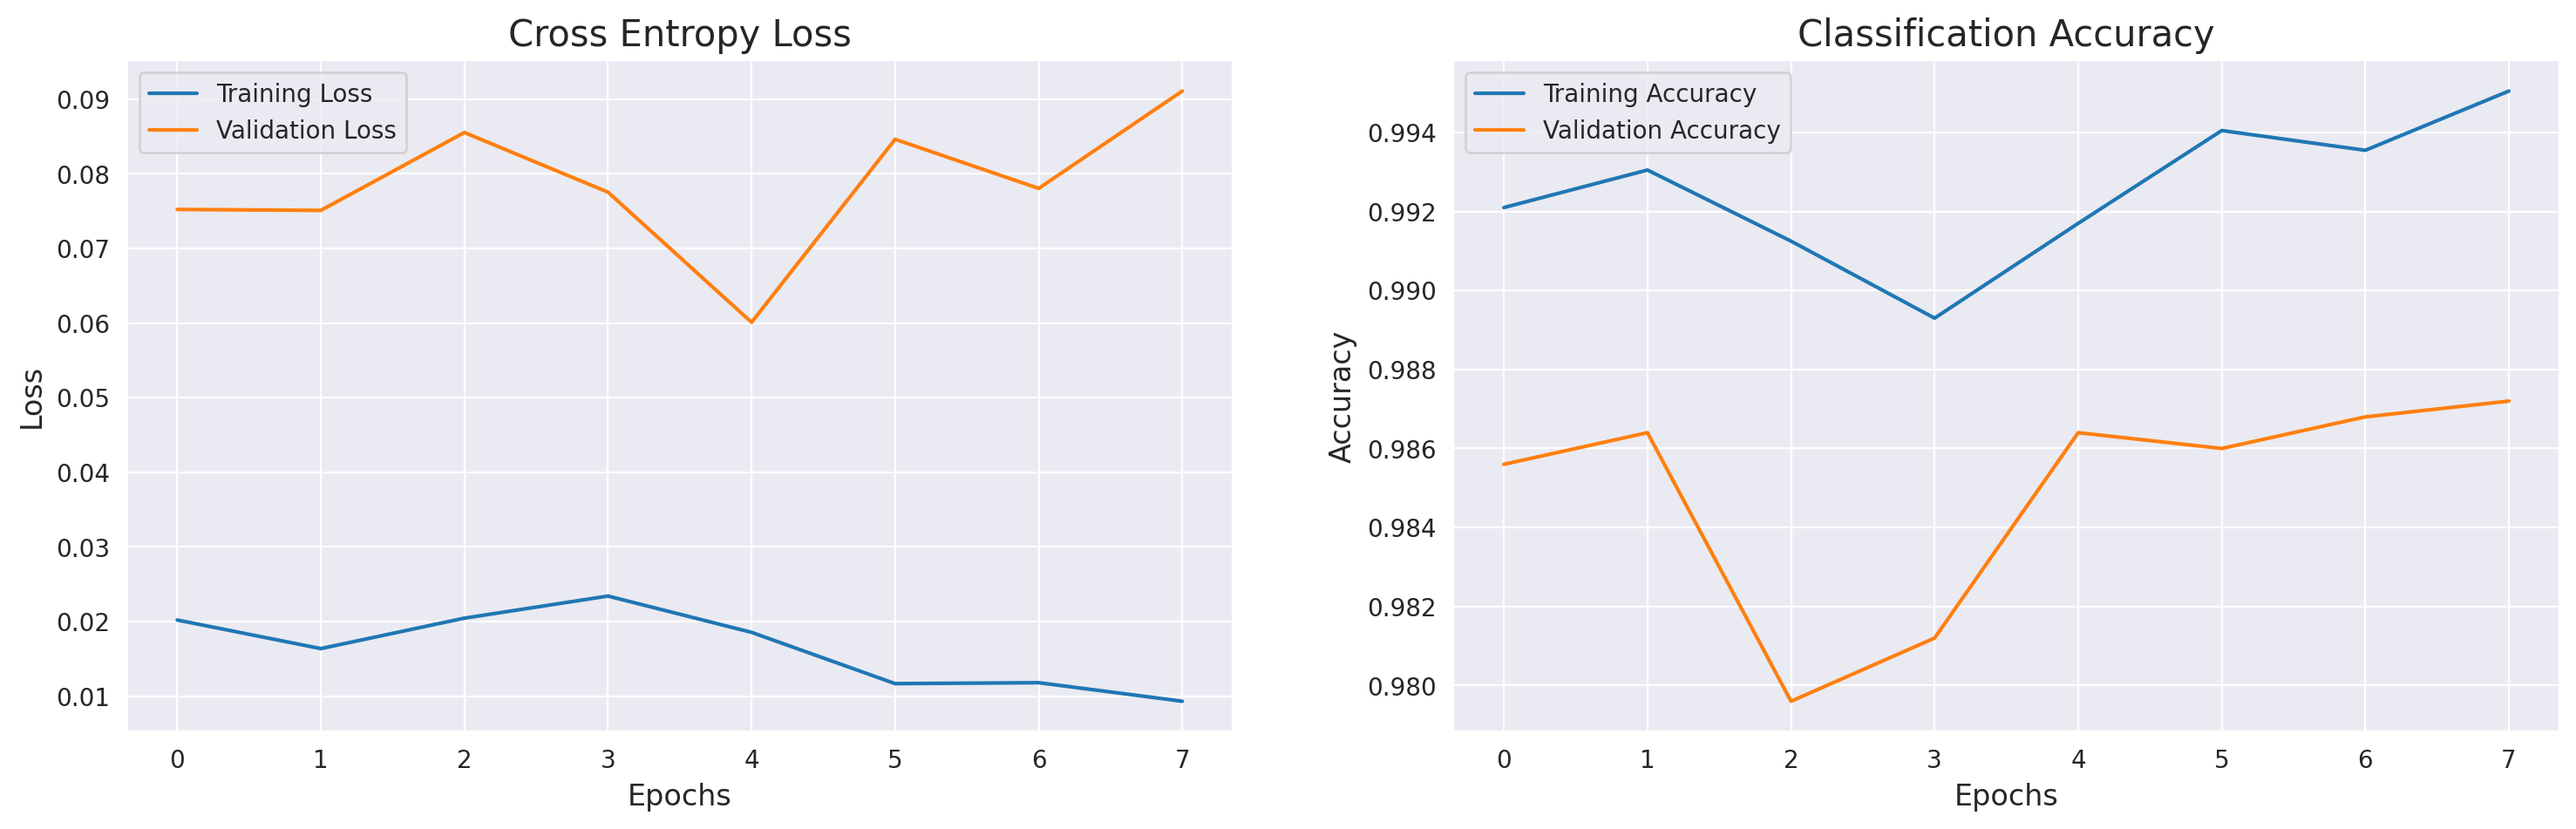

In [75]:
error = pd.DataFrame(cat_dog2.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error['loss'], label='Training Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend(loc='upper left')

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error['accuracy'], label='Training Accuracy')
plt.plot(error['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')

plt.show()

## Evaluation

In [71]:
# Evaluvate for train generator
loss, acc = final_model.evaluate(train_idg, batch_size=batch_size, verbose=1)

print('The accuracy of the model for training data is:', acc * 100)
print('The Loss of the model for training data is:', loss)

# Evaluvate for validation generator
loss, acc = final_model.evaluate(val_idg, batch_size=batch_size, verbose=1)

print('The accuracy of the model for validation data is:', acc * 100)
print('The Loss of the model for validation data is:', loss)

313/313 [==============================] - 250s 797ms/step - loss: 0.0026 - accuracy: 0.9987
The accuracy of the model for training data is: 99.86500144004822
The Loss of the model for training data is: 0.0025890571996569633
40/40 [==============================] - 31s 777ms/step - loss: 0.0601 - accuracy: 0.9864
The accuracy of the model for validation data is: 98.64000082015991
The Loss of the model for validation data is: 0.06010305881500244


## Saving model

In [76]:
final_model.save('cat_vs_dog_vgg16_model.keras')

## Prediction

In [77]:
result = final_model.predict(test_idg, batch_size=batch_size, verbose=1)

y_pred = np.argmax(result, axis=1)

y_true = test_idg.labels

# Evaluate
loss, acc = final_model.evaluate(test_idg, batch_size=batch_size)

print('\nThe accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)

40/40 [==============================] - 33s 803ms/step - loss: 0.0760 - accuracy: 0.9812

The accuracy of the model for testing data is: 98.11999797821045
The Loss of the model for testing data is: 0.07601970434188843


## Report

In [79]:
labels = ['Cat', 'Dog']
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

         Cat       0.98      0.98      0.98      1250
         Dog       0.98      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



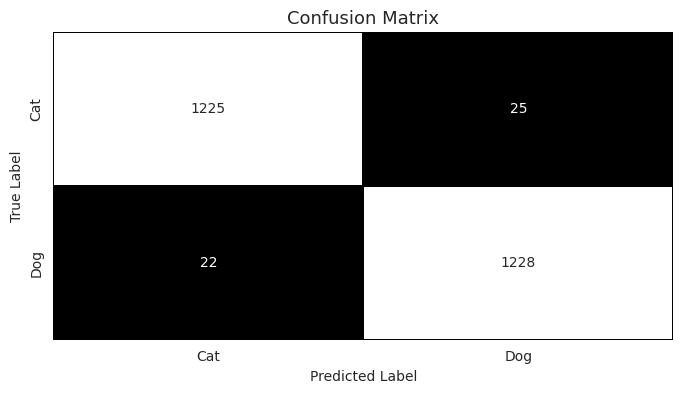

In [81]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(8,4), dpi=100)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax, cbar=False, xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()

In [92]:
# loading into dataframe
test_dir = "test/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     "test/test1/",
                                     x_col="filename",
                                     y_col='label',
                                     batch_size=batch_size,
                                     target_size=size,
                                     shuffle=False)

# Test Prediction
test1_predict = final_model.predict(test1_idg, verbose=1)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

Found 12500 validated image filenames belonging to 1 classes.
196/196 [==============================] - 162s 826ms/step


,filename,label
0,5448.jpg,dog
1,1273.jpg,dog
2,7682.jpg,cat
3,1589.jpg,cat
4,9885.jpg,dog


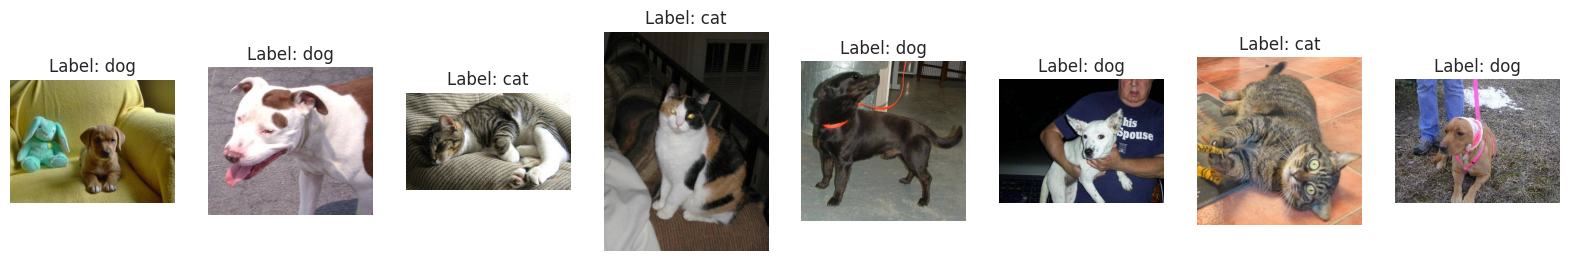

In [94]:
fig, axes = plt.subplots(1, 8, figsize=(20, 4))

for idx in range(8):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')

plt.show()

## Conclusion

Well, it turned out to be a good research work. I really enjoyed completing this test task. It seemed like a classic classification task, but it gave me real pleasure. I spent two days on it, which I absolutely do not regret. The model based on the pretrained VGG16 model showed better results. Which is not surprising. This is indicated by the metrics and confusion matrix.